# Simulating Observing Within the TRAPPIST-1 System#

<center><img src="trappistTravelbureau.jpg" alt="Drawing" style="width: 30%;"/></center>

The TRAPPIST-1 exoplanet system was originally found to have 3 short-period transiting planets orbiting a cool M-dwarf star in May 2015. Later, in 2017, the system was shown to have at least 7 planets of which at least 3 (TRAPPIST-1 e, f, g) are in the Goldilocks zone for liquid surface water. Morley et. al 2017 generated a grid of models for these planets among many for different assumptions of surface pressures, bond albedos, and atmosphere compositions.

Here I assume the observer planet is TRAPPIST-1 f, with an Earth-like atmosphere, $A_\mathrm{B} = 0.3$, and $P_{\mathrm{surf}} = 1$ bar. We are observing our immediate neighbor: TRAPPIST-1 g with a Titan-like atmosphere, $A_{\mathrm{B}}=0$, and $P_{\mathrm{surf}} = 0.001$ bar. The geometry is such that we are observing this planet at night through our own atmosphere. Since the target has no albedo and will not reflect the light of our host star, we do not include it in our analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from spectroscopy import planck_flux
from astropy import units as u
from scipy.optimize import fmin as minimize
from astropy import constants as const
from ipywidgets import *
from astropy.convolution import convolve, Gaussian1DKernel
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 1000
import seaborn as sns
sns.set_context("talk")
sns.set_style("darkgrid")

In [2]:
inner_planet = np.loadtxt('trappist1f_psurf1.0_alb0.3_chem_earth.spec',
                          skiprows=4)
outer_planet = np.loadtxt('trappist1g_psurf0.001_alb0.0_chem_titan.spec',
                          skiprows=4)
inner_mask = np.where((inner_planet[:,0]> 0.8)
                      & (inner_planet[:,0] < 30.0))
outer_mask = np.where((outer_planet[:,0]> 0.8)
                      & (outer_planet[:,0] < 30.0))

wien_constant = 2897.77729 #micron K 
inner_lambda_max = inner_planet[:,0][np.argmax(inner_planet[:,1])]
inner_temp_surf = wien_constant/inner_lambda_max
outer_lambda_max = outer_planet[:,0][np.argmax(outer_planet[:,1])]
outer_temp_surf = wien_constant/outer_lambda_max

inner_planck = planck_flux(inner_planet[:,0]*u.m/(10.0**6),
                           inner_temp_surf*u.K)
inner_factor = (np.max(inner_planet[:, 1])/np.max(inner_planck))
inner_planck = inner_planck*inner_factor
inner_res = minimize(lambda x: np.sum(np.abs((x[1]*planck_flux(inner_planet[:,0]*u.micron,
                                                               x[0]*u.K)).value
                                             - inner_planet[:,1])),
                     [inner_temp_surf, inner_factor.value])
inner_planck = inner_res[1]*planck_flux(inner_planet[:,0]*u.micron,
                                        inner_res[0]*u.K)

outer_planck = planck_flux(outer_planet[:,0]*u.m/(10.0**6),
                           outer_temp_surf*u.K)
outer_factor = (np.max(outer_planet[:, 1])/np.max(outer_planck)).value
outer_planck = outer_planck*outer_factor
outer_res = minimize(lambda x: np.sum(np.abs((x[1]*planck_flux(outer_planet[:,0]*u.micron,
                                                               x[0]*u.K)).value
                                             - outer_planet[:,1])),
                     [outer_temp_surf, outer_factor])

outer_planck = planck_flux(outer_planet[:,0]*u.micron, outer_res[0]*u.K)*outer_res[1]

Optimization terminated successfully.
         Current function value: 578147950.439309
         Iterations: 106
         Function evaluations: 202
Optimization terminated successfully.
         Current function value: 25955690.604147
         Iterations: 78
         Function evaluations: 148


In [3]:
outer_ang_size = ((1.127*const.R_earth)/(0.008*const.au)).decompose()
outer_angular_area = 2.0*np.pi*(1.0 - np.cos(outer_ang_size.value))

inner_resids = np.abs(inner_planet[:,1] - inner_planck.value)
inner_max_absorption_loc = np.argmax(inner_resids)
inner_tau_max = -np.log(inner_planet[:,1][inner_max_absorption_loc]
                        /inner_planck.value[inner_max_absorption_loc])

def get_eq_skin(star_temp, albedo, star_rad, planet_orb):
    eq_temp = star_temp*((1.0 - albedo)**0.25)*np.sqrt((star_rad/(2.0*planet_orb)).decompose())
    return eq_temp, eq_temp/(2.0**0.25)

inner_eq, inner_skin = get_eq_skin(2550.0, 0.3, 0.114*const.R_sun, 0.0451*const.au)

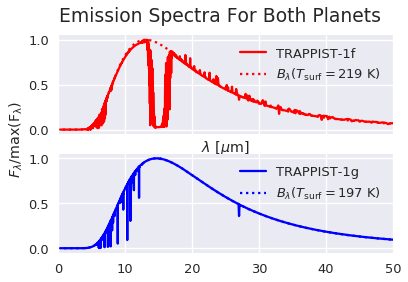

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(inner_planet[:, 0], inner_planet[:, 1]/np.max(inner_planet[:, 1]),
         '-r',label="TRAPPIST-1f")
ax2.plot(outer_planet[:, 0], outer_planet[:, 1]/np.max(outer_planet[:, 1]),
         '-b',label="TRAPPIST-1g")
ax1.plot(inner_planet[:,0], inner_planck.value/np.max(inner_planck.value),
         ':r',
         label=r'$B_{\lambda}(T_{\mathrm{surf}} =$'
         + str(int(inner_temp_surf))
         + ' K)')
ax2.plot(outer_planet[:,0], outer_planck.value/np.max(outer_planck.value),
         ":b",
         label=r'$B_{\lambda}(T_{\mathrm{surf}} = $'
         + str(int(outer_temp_surf))
         + ' K)')
ax1.set_xlabel(r'$\lambda$ [$\mu$m]')
ax2.set_ylabel(r'$F_{\lambda}/\mathrm{max(F_\lambda})$')
ax2.yaxis.set_label_coords(-0.1, 1.15)
ax1.legend()
ax1.set_xlim(0.0, 50.0)
ax2.legend()
plt.suptitle('Emission Spectra For Both Planets')
plt.savefig('emission_both.pdf')
plt.show()

Emission Spectrum:
$$F_\lambda = \left(B_{\lambda}(T_\mathrm{surf})e^{-\tau_\lambda} + \int_{0}^{\tau_\lambda} B_\lambda (T_{\tau_{\lambda}'})e^{-\tau_{\lambda}'}d\tau_{\lambda}' \right)\times 2\pi\left(1 - \cos{\theta}\right)$$
where $\theta$ is the angular radius of the object. Plotted above are the emission spectra for both the observer and target planet along with the spectra of blackbodies at the respective surface temperatures of both planets.

Conceptually, looking from outside the atmosphere, where $\tau_\lambda$ is the optical depth from the surface to the top of the atmosphere, the flux we see is a combination of the surface radiating upwards (decayed by $e^{-\tau_\lambda}$) and individual slabs of the atmosphere radiating at their own temperatures (with their own corresponding decay).

The details of these components do not matter at all for our target planet since the model emission spectrum provided by Morley et al. 2017 is all we care about. However, to incorporate the atmosphere of our own observer planet, we must know what our atmosphere radiates towards our telescope, picking out the integral term from the model emission spectrum provided.

Fortunately, our atmosphere is transparent at many wavelengths, allowing us to see the overall blackbody shape corresponding to the surface temperature which we can solve for. We also have a very deep absorption feature around 15 $\mu$m which will help us pick out the integral component we care for.

Finding $F_{\lambda_{min}}$ and comparing it to what $B_{\lambda_{min}}(T_\mathrm{surf})$ should be at that wavelength, we can solve for the maximum $\tau_\lambda$. Then, by assuming $T_{\tau_\lambda}$ varies linearly with $\tau_\lambda$ from $T_{\mathrm{surf}}$ to $T_{\mathrm{skin}}$, and using Taylor expansions to approximate the integral $\int_{0}^{\tau_{\lambda}} B_{\lambda} (T_{\tau_{\lambda}'})e^{-\tau_{\lambda}'}d\tau_{\lambda}'$, we can solve for $\tau_\lambda(\lambda)$, then use that to find only the integral component. Assuming the atmosphere radiates isotropically, this is the specific intensity that radiates down towards our telescope.

$$F_\lambda = \left(B_{\lambda}(T_\mathrm{surf})e^{-\tau_\lambda} + \int_{0}^{\tau_\lambda} B_\lambda (T_{\tau_{\lambda}'})e^{-\tau_{\lambda}'}d\tau_{\lambda}' \right)\times 2\pi\left(1 - \cos{\theta}\right)$$

$$T(\tau_{\lambda}') = T_{\mathrm{skin}} + \frac{T_{\mathrm{surf}} - T_{\mathrm{skin}}}{\tau_{\lambda_{\mathrm{max}}}}\times \tau_{\lambda}'$$

In [5]:
def find_optical_depth(tau_max, flux, wavelength,
                       surf_temp, eq_temp, skin_temp):
    temp_slope = u.K*(surf_temp - skin_temp)/(tau_max)
    m = temp_slope
    temp_intercept = skin_temp*u.K
    b = temp_intercept
    exp_factor = const.h*const.c/const.k_B
    test_taus = np.linspace(0.0, tau_max, 1000)
    final_taus = np.empty_like(wavelength)
    for i in range(0, len(wavelength)):
        wave = wavelength[i]*u.micron
        surf_term = planck_flux(wave, surf_temp*u.K)*np.exp(-test_taus)
        common_factor = 2.0*const.h*(const.c**2.0)/(wave**5.0)
        other_exp = (exp_factor/(wave)).decompose().value
        a = (const.h*const.c/(const.k_B*wave)).decompose()
        term_one = (test_taus**2.0)/(2.0*(np.exp(a/b) - 1.0))
        term_two = ((a*m*np.exp(a/b))*
                    (test_taus**3.0)/(6.0*(b**2.0)*
                                      (np.exp(a/b)
                                       - 1.0)**2.0))
        term_three = ((a*(m**2.0)*np.exp(a/b))*
                    (test_taus**4.0)/(24.0*(b**4.0)*
                                      (np.exp(a/b)
                                       - 1.0)**3.0))
        term_three = term_three*(a*np.exp(a/b)
                                 - 2.0*b*np.exp(a/b)
                                 + a + 2.0*b)
        test_integral = (surf_term
                         + common_factor*(term_one
                                          + term_two + term_three))
        diff = np.abs(flux[i]*(u.W/(u.m**3.0))
                      - 0.05738*test_integral.to(u.W/(u.m**3.0)))
        final_taus[i] = test_taus[np.argmin(diff)]
    return final_taus

low = 0
high = len(inner_planet[:,0])
inner_tau_lambda = find_optical_depth(inner_tau_max,
                                      inner_planet[low:high,1],
                                      inner_planet[low:high,0],
                                      inner_temp_surf,
                                      inner_eq,
                                      inner_skin)
inner_tau_lambda[np.where(inner_planet[:,0] > 20.0)] = 0.0

/home/gmduvvuri/miniconda3/envs/astroconda/lib/python3.5/site-packages/astropy/units/quantity.py:641: RuntimeWarning: overflow encountered in multiply
  *arrays, **kwargs)
/home/gmduvvuri/miniconda3/envs/astroconda/lib/python3.5/site-packages/astropy/units/quantity.py:641: RuntimeWarning: overflow encountered in power
  *arrays, **kwargs)


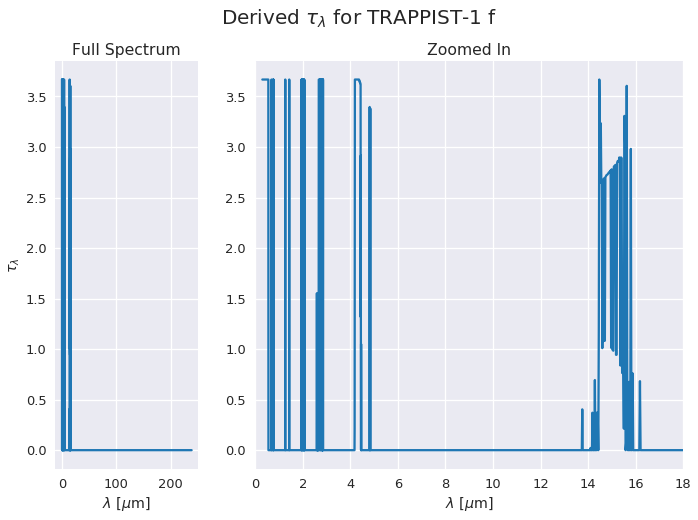

In [6]:
fig = plt.figure(figsize=(7.5*1.5, 5*1.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax1.plot(inner_planet[:, 0], inner_tau_lambda)
ax2.plot(inner_planet[:, 0], inner_tau_lambda)
ax1.set_xlabel(r'$\lambda$ [$\mu$m]')
ax2.set_xlabel(r'$\lambda$ [$\mu$m]')
ax1.set_ylabel(r'$\tau_\lambda$')
ax2.set_xlim(0.0, 18.0)
ax1.set_title('Full Spectrum')
ax2.set_title('Zoomed In')
plt.suptitle(r'Derived $\tau_\lambda$ for TRAPPIST-1 f', fontsize=20)
plt.savefig('tau_lambda.pdf')
plt.show()

In [7]:
def get_background_integral(wavelength, tau_lambdas, surf_temp, skin_temp):
    tau_max = np.max(tau_lambdas)
    temp_slope = u.K*(surf_temp - skin_temp)/(tau_max)
    m = temp_slope
    temp_intercept = skin_temp*u.K
    b = temp_intercept
    exp_factor = const.h*const.c/const.k_B
    integral_numbers = np.empty_like(wavelength)
    for i in range(0, len(wavelength)):
        wave = wavelength[i]*u.micron
        a = (const.h*const.c/(const.k_B*wave)).decompose()
        if tau_lambdas[i] > 0.00001:
            tau_arr = np.linspace(0.0, tau_lambdas[i], 1000)
            temp_arr = m*tau_arr + b
            integrand = ((planck_flux(wave, temp_arr).to(u.W/((u.m**2.0)*u.micron)))/np.pi)*np.exp(-tau_arr)
            integral_numbers[i] = np.trapz(integrand.value, tau_arr)
        else:
            integral_numbers[i] = 0.0
    return integral_numbers*((u.W/((u.m**2.0)*u.micron)))

inner_background_integral = get_background_integral(inner_planet[:,0], inner_tau_lambda, inner_temp_surf, inner_skin)

    

The model provided must be consistent with the spectrograph we assume, so we convolve it with a Gaussian kernel to match the resolution we assume, and then multiplied by the throughput of the telescope ($f$, letting through anywhere between 0% and 100% of the light). The flux we observe from our target is this convolved emission spectrum of TRAPPIST-1 g modified by the angular size of the target, the collecting area of our telescope ($A$), and the exposure time ($t$):
$$\mathrm{Signal} = \left(F_\lambda * G\left(\frac{\lambda_\mathrm{mean}}{R}\right)\right) \times \frac{\pi R_p^2}{4\pi d^2} \times A \times t \times \frac{\lambda}{hc}$$
where $R_p$ is the radius of TRAPPIST-1 g and $d$ is the distance between TRAPPIST-1 f and g, which we assume is simply the difference between their orbital distances (TRAPPIST-1 g is in perfect opposition and both planets are on perfectly circular orbits).

The noise is a combination of the Poisson noise of our signal, the Poisson noise of the flux from our own atmosphere which we circuitously (and only loosely approximately) solved for above, and white noise due to instrumental limitations ($\sigma^2$):
$$\mathrm{Noise}=\sqrt{\mathrm{Signal} + \left(\int_{0}^{\tau_{\lambda}} B_{\lambda} (T_{\tau_{\lambda}'})e^{-\tau_{\lambda}'}d\tau_{\lambda}' \times f \times A \times t\times 2\pi\left(1 - \cos{\theta}\right)\times \frac{\lambda}{hc}\right) + \sigma^2}$$

Then the SNR is simply:
$$\mathrm{SNR} = \frac{\mathrm{Signal}}{\mathrm{Noise}}$$ 

For the purposes of our simulation, the parameters we can vary are:
$$R, f, t, A, \sigma^2$$

Of these, $A$ we vary by changing the diameter of the telescope, and use $\log{\sigma^2}$ and $\log{R}$ instead of the values directly. For a wavelength range between $\lambda_\mathrm{min}$ and $\lambda_\mathrm{max}$ we can show the SNR as a function of wavelength and the true SNR is a mean over this function. Below, we allow these parameters to be varied and show the mean SNR integrated over the range specified using an interactive widget.

In [8]:
def get_outer_flux(throughput, wave_min, wave_max, resolution):
    outer_planet_flux_received = throughput*outer_planet[:,1]*(outer_ang_size**2.0)/4.0
    width = (np.mean([wave_min, wave_max])/resolution)
    d_lambda = np.mean(np.diff(outer_planet[:,0]))
    kernel = Gaussian1DKernel(width)
    outer_planet_flux_observed = convolve(outer_planet_flux_received, kernel)
    outer_flux = outer_planet_flux_observed*(u.W/(u.m**3.0))
    outer_flux = outer_flux.to(u.W/(u.micron*(u.m**2.0)))
    return outer_flux

def get_signal(flux, wavelength, area, time):
    return (flux*area*time/(const.h*const.c)).decompose()

def get_noise(flux, wavelength, background_integral, area,
              time, white_noise_variance, signal, throughput):
    background_term = background_integral*outer_angular_area*throughput*area*time/(const.h*const.c)
    return np.sqrt((signal*wavelength).decompose().value
                   + background_term.decompose().value
                   + white_noise_variance)

def get_snr(signal, noise):
    return signal.value/noise

def get_snr_integrated(snr, wavelength, wave_min, wave_max):
    mask = np.where((wavelength.value < wave_max)
                    & (wavelength.value >= wave_min))
    return np.mean((wavelength[mask].value*snr[mask])
                   /np.mean(wavelength[mask].value))

def calc_snr(area, time, white_noise_variance,
             throughput, resolution, wave_low, wave_high):
    outer_flux = get_outer_flux(throughput, wave_low, wave_high, resolution)
    signal = get_signal(outer_flux, outer_planet[:,0]*u.micron, area, time)
    noise = get_noise(outer_flux, outer_planet[:,0]*u.micron,
                      inner_background_integral, area, time,
                      white_noise_variance, signal, throughput)
    snr = get_snr(signal, noise)
    return snr,signal, noise, outer_flux

def plot_snr(telescopeD, time, log_variance,
             throughput, log_resolution, wave_low, wave_high):
    radius = telescopeD/2.0
    area = np.pi*((radius*u.cm)**2.0)
    time = time*u.s
    white_noise_variance = 10.0**log_variance
    resolution = 10.0**log_resolution
    snr, signal, noise, outer_flux = calc_snr(area, time, white_noise_variance,
                   throughput, resolution, wave_low, wave_high)
    integrated_snr = get_snr_integrated(snr,
                                        outer_planet[:,0]*u.micron,
                                        wave_low, wave_high)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 15))
    mask = np.where((outer_planet[:,0] > wave_low) & (outer_planet[:, 0] < wave_high))
    signal = signal[mask]
    noise = noise[mask]
    snr = snr[mask]
    outer_flux = outer_flux[mask]
    waves_masked = outer_planet[:,0][mask]
    ax1.plot(waves_masked, snr, '-b')
    ax2.plot(waves_masked, signal/np.max(signal.value), '-b')
    ax2.fill_between(waves_masked,
                     signal.value/np.max(signal.value) + noise/np.max(signal.value),
                     signal.value/np.max(signal.value)  - noise/np.max(signal.value) , color='r')
    ax3.step(waves_masked, np.random.normal(outer_flux.value, outer_flux.value/(snr)), 'k')
    ax3.set_ylabel(r'$F_{\lambda}$ [W m$^{-2}$ $\mu$m$^{-1}$]')
    ax3.set_xlabel(r'$\lambda$ [$\mu$m]')
    ax1.set_ylabel(r'$\mathrm{SNR}_\lambda$')
    ax2.set_ylabel(r'$\mathrm{Signal}/\mathrm{max(Signal)}$')
    ax1.set_xlim(wave_low, wave_high)
    suptitle_label = r'$A=$' + "{:.1f}".format(area.value) + r' cm$^2$, '
    suptitle_label += r'$t=$' + "{:.1f}".format(time.value) + r' s, '
    suptitle_label += r'$\sigma^2 =$' + "{:.2E}".format(white_noise_variance) + r', '
    suptitle_label += r'$f=$' + "{:.1f}".format(throughput) + r', '
    suptitle_label += r'$R=$' + "{:.1f}".format(resolution) + r', '
    suptitle_label += r'$\langle \mathrm{SNR}\rangle =$ ' + "{:.2E}".format(integrated_snr)
    plt.suptitle(suptitle_label, x=0.55, y=1.02)
    plt.tight_layout()
    plt.show()
    
interact(plot_snr, telescopeD=(0.1, 20.0, 0.1),
         time=(0.0, 10.0, 0.10), log_variance=(25.0, 45.0, 1.0),
         throughput=(0.0, 1.0, 0.1), log_resolution=(1.0, 5.0, 0.05),
         wave_low = (0.0, 10.0, 1.0), wave_high=(20.0, 50.0, 1.0), )

interactive(children=(FloatSlider(value=10.0, description='telescopeD', max=20.0, min=0.1), FloatSlider(value=5.0, description='time', max=10.0), FloatSlider(value=35.0, description='log_variance', max=45.0, min=25.0, step=1.0), FloatSlider(value=0.5, description='throughput', max=1.0), FloatSlider(value=3.0, description='log_resolution', max=5.0, min=1.0, step=0.05), FloatSlider(value=5.0, description='wave_low', max=10.0, step=1.0), FloatSlider(value=35.0, description='wave_high', max=50.0, min=20.0, step=1.0), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_snr>

"telescopeD": Telescope diameter in cm

"time": $t$ in s

"log_variance": $\log{\sigma^2}$

"throughput": $f$

"log_resolution": $\log{R}$

"wave_low": $\lambda_\mathrm{min}$

"wave_high": $\lambda_\mathrm{max}$

## References ##

Morley, C.~V., Kreidberg, L., Rustamkulov, Z., Robinson, T., & Fortney, J.~J. 2017, ApJ, 850, 121 